In [1]:
import numpy as np
import pandas as pd
import pickle

class LigandComparer():
    def __init__(self, similarity_pkl):
        with open(similarity_pkl,"rb") as f:
            sim_mat, pdbids = pickle.load(f)
        self.sim_mat = sim_mat
        self.pdbids = pdbids
        self.pdbid_map = {pdbid: idx for idx, pdbid in enumerate(pdbids)}
        
    def get_sim(self, pdbid1, pdbid2):
        if pdbid1 not in self.pdbid_map or pdbid2 not in self.pdbid_map:
            return 0
        id1=self.pdbid_map[pdbid1]
        id2=self.pdbid_map[pdbid2]
        return self.sim_mat[id1,id2]
    
    def get_all_sims(self, pdbid, list_pdbid_to_compare):
        if pdbid not in self.pdbid_map:
            return np.zeros(len(list_pdbid_to_compare))
        compare_idx = np.array([self.pdbid_map.get(pid, np.nan) for pid in list_pdbid_to_compare])
        result=np.zeros(len(list_pdbid_to_compare))
        exist=~np.isnan(compare_idx)
        result[exist]=self.sim_mat[self.pdbid_map[pdbid], compare_idx[exist].astype(int)]
        return result

class ProteinComparer():
    def __init__(self, similarity_pkl):
        with open(similarity_pkl,"rb") as f:
            data = pickle.load(f)
        self.pdbid_categories={}
        self.pdbid_map={}
        self.similarities={}
        for category in data:
            self.similarities[category]=data[category][1]
            for idx,pdbid in enumerate(data[category][0]):
                self.pdbid_map[pdbid]=idx
                self.pdbid_categories[pdbid]=category
                
    def get_category(self, pdbid):
        return self.pdbid_categories.get(pdbid, "unknown")
    
    def get_sim(self, pdbid1, pdbid2):
        cat1 = self.get_category(pdbid1)
        cat2 = self.get_category(pdbid2)
        if cat1 == "unknown" or cat2 == "unknown" or cat1!=cat2:
            return 0
        id1=self.pdbid_map[pdbid1]
        id2=self.pdbid_map[pdbid2]
        
        if id1>id2:
            id1,id2=id2,id1
            
        return self.similarities[cat1][(id1,id2)]
    
    def get_all_sims(self, pdbid, list_pdbid_to_compare):
        if pdbid not in self.pdbid_map:
            return np.zeros(len(list_pdbid_to_compare))
        cat=self.get_category(pdbid)
        source_id=self.pdbid_map[pdbid]
        final_results = []
        for comp_id in list_pdbid_to_compare:
            if self.get_category(comp_id) != cat:
                final_results.append(0)
            else:
                this_idx=self.pdbid_map[comp_id]
                id1,id2=source_id,this_idx
                if id1>id2:
                    id1,id2=id2,id1
                elif id1==id2:
                    final_results.append(1)
                    continue
                final_results.append(self.similarities[cat][(id1,id2)])
        return np.array(final_results)

lig_comp = LigandComparer("ligand_sim.pkl")
prot_comp = ProteinComparer("protein_identities.pkl")

In [2]:
import pandas as pd
info=pd.read_csv("info_with_type.csv",index_col=0)
info["date"]=pd.to_datetime(info["date"])

In [3]:
prot_val_cutoff=0.5   # any protein in the train set should have at most 20% similarity to the test set
prot_test_cutoff=0.9  # any protein in the val set should have at most 50% similarity to the test set
lig_val_cutoff=0.99    # any ligand in the train set should have at most 40% similarity to the test set
lig_test_cutoff=0.99   # any ligand in the val set should have at most 80% similarity to the test set
prot_train_val_cutoff=prot_val_cutoff  # any protein in the train set should have at most 20% similarity to the val set
lig_train_val_cutoff=lig_val_cutoff  # any ligand in the train set should have at most 40% similarity to the val set

In [4]:
info.type.value_counts()

hydrolase           5733
transferase         5291
other               3589
transcription        992
lyase                867
transport            621
oxidoreductase       576
ligase               470
isomerase            333
chaperone            300
membrane             284
viral                267
metal_containing     120
Name: type, dtype: int64

In [5]:
selected_type="hydrolase"
type_df = info[info.type==selected_type]

In [6]:
working_set = set(type_df.index)
train = set()
val = set()
test = set()
# Select seed test cases (date>2019)

# test_working = set(type_df[type_df.date>="2019-03-01"].index)
test_working = set(type_df.sample(5).index)
test = set(test_working)
print(len(test))
while len(test_working) > 0:
    test_new_round = set()
    
    working_set -= test_working
    for item in test_working:
        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)
        strict_criterion_selected = (prot_sims > prot_test_cutoff) | (lig_sims > lig_test_cutoff)
        add_to_test = wlist[strict_criterion_selected]

        working_set -= set(add_to_test)
        test |= set(add_to_test)
        test_new_round |= set(add_to_test)

        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)

        loose_criterion_selected = (prot_sims > prot_val_cutoff) | (lig_sims > lig_val_cutoff)
        add_to_val = wlist[loose_criterion_selected]

        working_set -= set(add_to_val)
        val |= set(add_to_val)

    test_working = test_new_round
    print(len(working_set), len(val), len(test), len(test_working))

print("="*50)
# now remove anything in train that is too similar to val
val_working = val.copy()
while len(val_working) > 0:
    val_new_round = set()
    working_set -= val_working
    for item in val_working:
        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)
        criterion_selected = (prot_sims > prot_train_val_cutoff) | (lig_sims > lig_train_val_cutoff)
        add_to_val = wlist[criterion_selected]

        working_set -= set(add_to_val)
        val |= set(add_to_val)
        val_new_round |= set(add_to_val)
    val_working = val_new_round
    print(len(working_set), len(val), len(test), len(val_working))

print(selected_type)
print(len(working_set), len(val), len(test))   


5
5466 12 255 250
5197 36 500 245
5047 66 620 120
5006 68 659 39
4529 119 1085 426
4504 128 1101 16
4484 130 1119 18
4473 130 1130 11
4449 141 1143 13
4449 141 1143 0
4439 151 1143 10
4436 154 1143 3
4435 155 1143 1
4426 164 1143 9
4426 164 1143 0
hydrolase
4426 164 1143


In [7]:
train=list(working_set)
val=list(val)
test=list(test)

In [8]:
prot_sim_train_test=np.zeros((len(test),len(train)))
lig_sim_train_test=np.zeros((len(test),len(train)))

prot_sim_train_val=np.zeros((len(val),len(train)))
lig_sim_train_val=np.zeros((len(val),len(train)))

prot_sim_val_test=np.zeros((len(test),len(val)))
lig_sim_val_test=np.zeros((len(test),len(val)))

for idx,id_test in enumerate(test):
    prot_sim_train_test[idx,:]=prot_comp.get_all_sims(id_test, train)
    lig_sim_train_test[idx,:]=lig_comp.get_all_sims(id_test, train)

    prot_sim_val_test[idx,:]=prot_comp.get_all_sims(id_test, val)
    lig_sim_val_test[idx,:]=lig_comp.get_all_sims(id_test, val)

for idx,id_val in enumerate(val):
    prot_sim_train_val[idx,:]=prot_comp.get_all_sims(id_val, train)
    lig_sim_train_val[idx,:]=lig_comp.get_all_sims(id_val, train)


max_prot_sim_test_to_train=np.max(prot_sim_train_test, axis=1)
max_lig_sim_test_to_train=np.max(lig_sim_train_test, axis=1)

max_prot_sim_val_to_train=np.max(prot_sim_train_val, axis=1)
max_lig_sim_val_to_train=np.max(lig_sim_train_val, axis=1)



In [ ]:
prot_sim_val_test

Text(0.5, 1.0, '1.0')

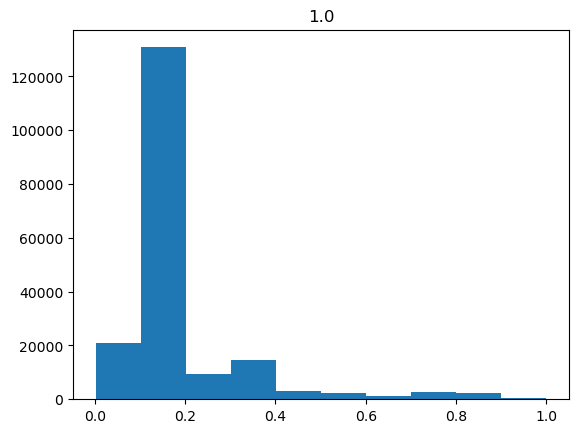

In [11]:
import matplotlib.pyplot as plt

# item=max_prot_sim_val_to_train
# item=max_prot_sim_test_to_train
item=prot_sim_val_test.flatten()
plt.hist(item);
plt.title(str(np.max(item)))


Text(0.5, 1.0, '0.3188405797101449')

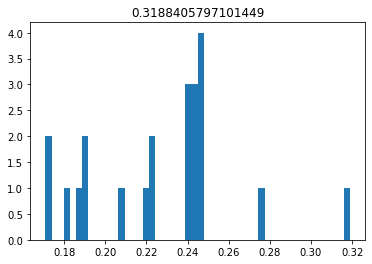

In [148]:
import matplotlib.pyplot as plt

# item=max_prot_sim_val_to_train
item=max_prot_sim_test_to_train
# item=prot_sim_val_test.flatten()
plt.hist(item,bins=50);
plt.title(str(np.max(item)))


In [14]:
# split_dict = {}

In [149]:
type_split_dict = {selected_type: {
    "train": train,
    "val": val,
    "test": test
}}

In [150]:
import json
split_dict.update({selected_type: {
    "train": train,
    "val": val,
    "test": test
}})

with open("splits.json", "w") as f:
    json.dump(split_dict, f)


(array([  6.,  33.,  18.,  11.,   9.,  24.,  37., 181.,  49.,  22.]),
 array([0.18006993, 0.19206294, 0.20405594, 0.21604895, 0.22804196,
        0.24003497, 0.25202797, 0.26402098, 0.27601399, 0.28800699,
        0.3       ]),
 <BarContainer object of 10 artists>)

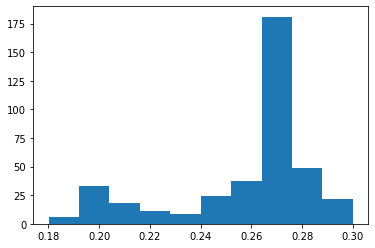

In [82]:
plt.hist(max_prot_sim_test_to_train)

(array([  2.,   0.,   1., 132., 162.,  23.,  12.,  30.,  19.,   9.]),
 array([0.        , 0.09733333, 0.19466667, 0.292     , 0.38933333,
        0.48666667, 0.584     , 0.68133333, 0.77866667, 0.876     ,
        0.97333333]),
 <BarContainer object of 10 artists>)

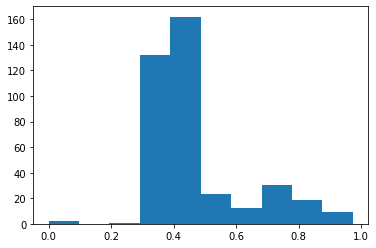

In [83]:
plt.hist(max_lig_sim_test_to_train)

In [84]:
max_lig_sim_test_to_train.argmax()

119

In [85]:
lig_sim_train_test[119].argmax()

346

In [86]:
lig_sim_train_test[119,346]

0.9733333333333334

In [74]:
test[12],train[231]

('4nb6', '1pqc')

In [46]:
list(test_cases)[1]

'6fzj'

(array([224., 520.,  89.,  19.,   1.,   0.,   7.,   0.,   7., 125.]),
 array([0.01118881, 0.11006993, 0.20895105, 0.30783217, 0.40671329,
        0.50559441, 0.60447552, 0.70335664, 0.80223776, 0.90111888,
        1.        ]),
 <BarContainer object of 10 artists>)

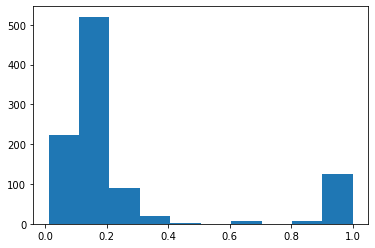

In [50]:
plt.hist(prot_comp.get_all_sims("6ajz", type_df.index))

In [34]:
lig_sims=lig_comp.get_all_sims("6jno",wlist)
prot_sims=prot_comp.get_all_sims("6jno",wlist)

(array([  8.,  25., 257., 379., 193.,  40.,  11.,   0.,   1.,   1.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ]),
 <BarContainer object of 10 artists>)

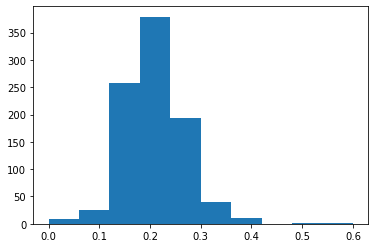

In [33]:
import matplotlib.pyplot as plt

plt.hist(lig_sims)

(array([484., 409.,  18.,   2.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.00251889, 0.09635567, 0.19019245, 0.28402923, 0.37786601,
        0.4717028 , 0.56553958, 0.65937636, 0.75321314, 0.84704992,
        0.9408867 ]),
 <BarContainer object of 10 artists>)

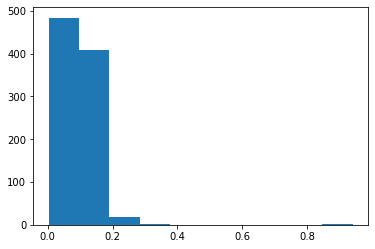

In [35]:
import matplotlib.pyplot as plt

plt.hist(prot_sims)

In [28]:
wlist=list(working_set)

In [23]:
type_df.loc[test_cases]

,header,smiles,category,seq,resolution,date,type
6jno,transcription,Cc1cc2c(cc1-c1cc3cc(C(=O)[O-])c(=O)oc3cc1O)C(C...,general,PVTNICQAADKQLFTLVEWAKRIPHFSELPLDDQVILLRAGWNELL...,2.65,2019-11-20,transcription
6fzj,transcription,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(...,general,ADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDINS...,2.01,2019-02-13,transcription
6q6m,transcription,CCOC(=O)[C@H](C)N(C(=O)c1cccs1)c1c(C)cccc1Cl,general,ASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQR...,2.35,2019-11-27,transcription
6ggg,transcription,CNC(=O)C[C@H]1COc2cc(F)c(CC(C)C)cc2N1C(=O)c1cc...,general,IVYAGYDKPDTAENLLSTLNRLAGKQMIQVVKWAKVLPGFKNLPLE...,1.71,2019-01-09,transcription
6pfj,transcription,NaN,general,LPELRTLRREAQSDEADLSYVRRMLQGRIDILRAELARRTDGEAPV...,2.08,2019-11-13,transcription
...,...,...,...,...,...,...,...
6dgr,transcription/transcription inhibitor,O=c1[nH]c(O)c(Cc2ccc(OCCc3cccs3)cc2)s1,refined,ESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDM...,2.15,2019-05-22,transcription
6j7e,transcription,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,refined,FRSLVGTSRAIQQVRQMMQQVADTDASVLILGESGTGKEVVARNLH...,2.40,2019-11-27,transcription
6sen,transcription,CSCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(C)=...,general,RSVASSKLWMLEFSAFLEQQQDPDTYNKHLFVHIGQSYLEAVDIRQ...,1.65,2019-11-20,transcription
6o7g,transcription,CNC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CCCNC(N)=...,general,SLVTCPICHAPYVEEDLLIQCRHCERWMHAGCESLFTEDDVEQAAD...,NaN,2019-05-22,transcription


In [18]:
(pd.to_datetime(type_df.date)>='2019-01-01').sum()

77

# Combining all categories

In [154]:
all_trains=np.concatenate([split_dict[cat]["train"] for cat in split_dict])
all_vals=np.concatenate([split_dict[cat]["val"] for cat in split_dict])
all_tests=np.concatenate([split_dict[cat]["test"] for cat in split_dict])

In [155]:
len(all_trains),len(all_vals),len(all_tests)

(12161, 2422, 4860)

In [156]:
prot_sim_test_train=np.zeros((len(all_tests),len(all_trains)))
lig_sim_test_train=np.zeros((len(all_tests),len(all_trains)))

prot_sim_val_train=np.zeros((len(all_vals),len(all_trains)))
lig_sim_val_train=np.zeros((len(all_vals),len(all_trains)))


for idx,id_train in enumerate(all_trains):
    prot_sim_test_train[:, idx]=prot_comp.get_all_sims(id_train, all_tests)
    lig_sim_test_train[:, idx]=lig_comp.get_all_sims(id_train, all_tests)

    prot_sim_val_train[:, idx]=prot_comp.get_all_sims(id_train, all_vals)
    lig_sim_val_train[:, idx]=lig_comp.get_all_sims(id_train, all_vals)
    



max_prot_sim_train_to_test=np.max(prot_sim_test_train, axis=0)
max_lig_sim_train_to_test=np.max(lig_sim_test_train, axis=0)

max_prot_sim_train_to_val=np.max(prot_sim_val_train, axis=0)
max_lig_sim_train_to_val=np.max(lig_sim_val_train, axis=0)

(array([  19.,  161., 4479., 6172.,  408.,  239.,  196.,  330.,   90.,
          67.]),
 array([0.04810298, 0.09329268, 0.13848238, 0.18367209, 0.22886179,
        0.27405149, 0.31924119, 0.36443089, 0.4096206 , 0.4548103 ,
        0.5       ]),
 <BarContainer object of 10 artists>)

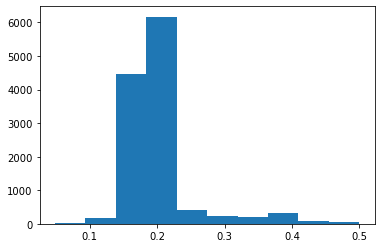

In [162]:
plt.hist(max_prot_sim_train_to_test)

(array([2.880e+02, 1.000e+00, 2.600e+01, 7.800e+02, 3.674e+03, 2.753e+03,
        1.703e+03, 1.467e+03, 7.780e+02, 6.910e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

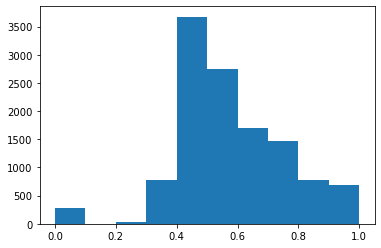

In [163]:
plt.hist(max_lig_sim_train_to_test)

In [165]:
(max_lig_sim_train_to_test>0.99).sum()

418

In [167]:
(max_lig_sim_train_to_val>0.99).sum()

273

In [168]:
filtered_train=all_trains[(max_lig_sim_train_to_test<0.99) & (max_lig_sim_train_to_val<0.99)]

In [169]:
len(filtered_train)

11513

In [173]:
info.loc[filtered_train,"new_split"]="train"

In [174]:
info.loc[all_vals,"new_split"]="val"
info.loc[all_tests,"new_split"]="test"

In [9]:
info.to_csv("info_with_new_split.csv")

(array([168., 428., 203., 237., 248., 383., 403., 185.,  83.,  84.]),
 array([0.16271963, 0.19644767, 0.23017571, 0.26390374, 0.29763178,
        0.33135982, 0.36508785, 0.39881589, 0.43254393, 0.46627196,
        0.5       ]),
 <BarContainer object of 10 artists>)

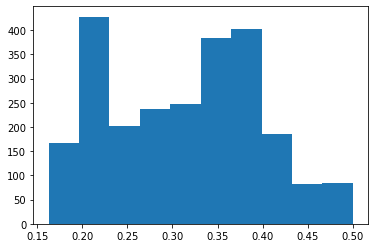

In [159]:
plt.hist(max_prot_sim_val_to_train)

In [3]:
import pandas as pd
new_split=pd.read_csv("info_with_new_split.csv")

In [5]:
info=pd.read_csv("info.csv",index_col=0)

In [6]:
info

,header,smiles,category,seq,resolution,date
6r8o,isomerase,CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...,refined,GNPLVYLDVDANGKPLGRVVLELKADVVPKTAENFRALCTGEKGFG...,1.36,2019-11-27
3fh7,hydrolase/hydrolase inhibitor,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,refined,VDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQEDNL...,2.05,2010-01-05
4b7r,hydrolase,CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...,refined,VKLAGNSSLCPVSGWAIYSKDNSVRIGSKGDVFVIREPFISCSPLE...,1.90,2012-10-03
3qfd,immune system,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...,refined,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,1.68,2011-09-28
3fvn,membrane protein,[NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...,refined,ANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNIL...,1.50,2010-01-19
...,...,...,...,...,...,...
6npt,transferase,CC(C)(C)c1ccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc...,general,IENCVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAV...,2.19,2019-05-22
3pax,transferase,COc1cccc(C(N)=O)c1,general,KSKLAKPIQDLIKMIFDVESMKKAMVEFEIDLQKMPLGKLSKRQIQ...,2.40,1998-05-27
5ezz,hydrolase/inhibitor,Cc1cc([C@@]2(c3cccc(-c4cncc(Cl)c4)c3)COC(=[NH2...,general,RGSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVG...,2.10,2016-02-24
1hgi,viral protein,CO[C@]1(C(=O)[O-])C[C@H](OC(C)=O)[C@@H](NC(C)=...,general,QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSS...,2.70,1994-01-31


In [7]:
new_split.index=info.index

In [10]:
new_split

,header,smiles,category,seq,resolution,date,type,new_split
6r8o,isomerase,CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...,refined,GNPLVYLDVDANGKPLGRVVLELKADVVPKTAENFRALCTGEKGFG...,1.36,2019-11-27,isomerase,test
3fh7,hydrolase/hydrolase inhibitor,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,refined,VDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQEDNL...,2.05,2010-01-05,hydrolase,test
4b7r,hydrolase,CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...,refined,VKLAGNSSLCPVSGWAIYSKDNSVRIGSKGDVFVIREPFISCSPLE...,1.90,2012-10-03,hydrolase,NaN
3qfd,immune system,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...,refined,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,1.68,2011-09-28,other,train
3fvn,membrane protein,[NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...,refined,ANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNIL...,1.50,2010-01-19,membrane,val
...,...,...,...,...,...,...,...,...
6npt,transferase,CC(C)(C)c1ccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc...,general,IENCVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAV...,2.19,2019-05-22,transferase,test
3pax,transferase,COc1cccc(C(N)=O)c1,general,KSKLAKPIQDLIKMIFDVESMKKAMVEFEIDLQKMPLGKLSKRQIQ...,2.40,1998-05-27,transferase,val
5ezz,hydrolase/inhibitor,Cc1cc([C@@]2(c3cccc(-c4cncc(Cl)c4)c3)COC(=[NH2...,general,RGSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVG...,2.10,2016-02-24,hydrolase,test
1hgi,viral protein,CO[C@]1(C(=O)[O-])C[C@H](OC(C)=O)[C@@H](NC(C)=...,general,QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSS...,2.70,1994-01-31,viral,train


In [11]:
new_split.to_csv("info_with_new_split.csv")